# Data Mining 1
## Neuronale Netze - Beispielprogramm
### Implementierung eines neuronalen Netzes ohne Hidden Layer

### 1 - Preparations
#### 1.1 - Imports

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import pandas as pd

# Display plots inline and change default figure size
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

#### 1.2 - Generating a dataset

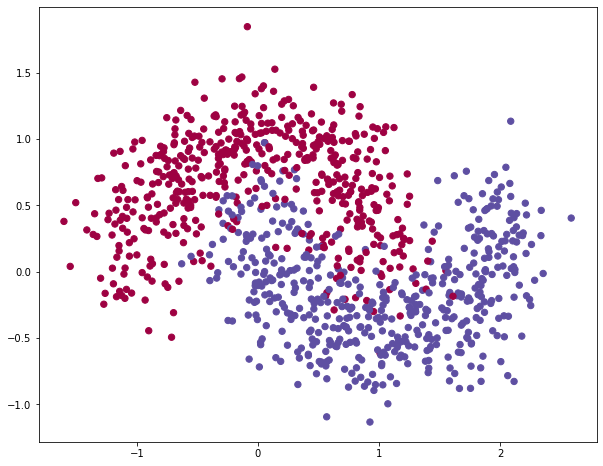

In [22]:
# Generate a dataset and plot it
n          = 1000
data_seed  = 1337
split_seed = 42
test_size  = 0.25

np.random.seed(data_seed)
X, y = sklearn.datasets.make_moons(n, noise=0.25)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral);

#### 1.3 - Split the dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=test_size, 
                                                    random_state=split_seed)

##### Training Data:

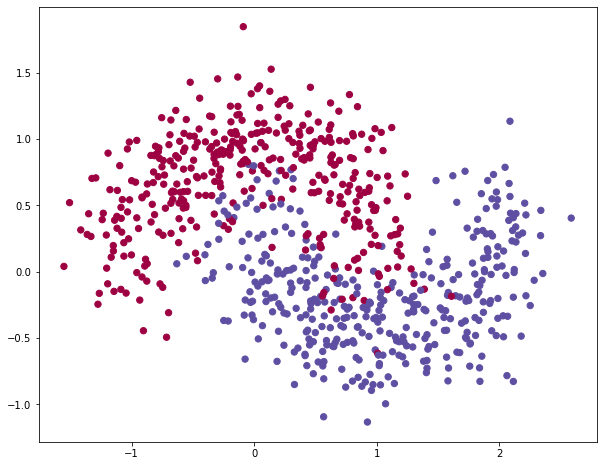

In [24]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral);

##### Validation Data:

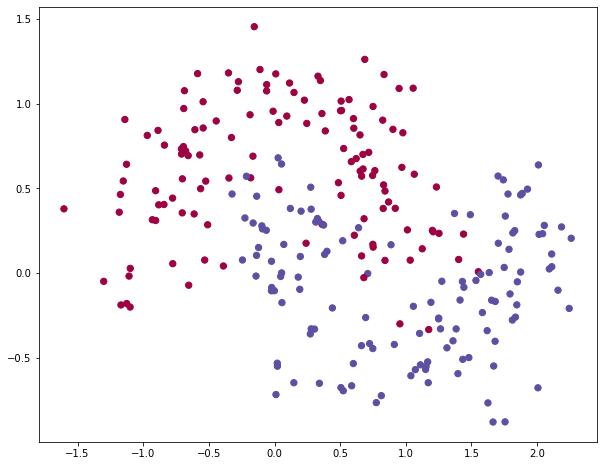

In [25]:
plt.scatter(X_test[:,0], X_test[:,1], s=40, c=y_test, cmap=plt.cm.Spectral);

### 2- Implementierung
#### 2.1 - Aktivierungsfunktion (activation function)
Als Aktivierungsfunktion des Output-Layers wird die logistische Funktion 

$\displaystyle \sigma\colon \,\mathbb{R}\to \left(0,1\right), \;z \mapsto\frac{1}{1+\exp(-z)}$ 

verwendet.

In [26]:
def sigmoid(z, derivation = False):
    if derivation:
        return sigmoid(z)*(1-sigmoid(z))
    else:
        return 1/(1+np.exp(-z))

value = 1
print(sigmoid(value))
print(sigmoid(value,True))

0.7310585786300049
0.19661193324148185


#### 2.2 Kostenfunktion (cost function)
Als Kostenfunktion wird folgende quadratische Fehlerfunktion verwendet:

$\displaystyle E(y,\widehat{\pi}) = \frac{1}{2}\sum_{k=1}^{n}\left(y_k-\widehat{\pi_k}\right)^2$

wobei $y=\left(y_1,\dots,y_n\right)^T$ und $\widehat{\pi}=\left(\widehat{\pi_1},\dots,\widehat{\pi_n}\right)^T$.

# Booklet teil 2
hier startet unsere Implementierung:

In [45]:
class NeuralNet:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate=0.1):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.learning_rate = learning_rate
        
        # set random seed to get reproducable results
        np.random.seed(5)
        
        #Glorot initialisation
        
        self.W_input_hidden = np.random.normal(0.0, 
                                               1/((self.input_nodes*self.hidden_nodes+self.hidden_nodes)/2), 
                                               (self.hidden_nodes, self.input_nodes))
        
        self.W_hidden_output = np.random.normal(0.0, 
                                               1/((self.hidden_nodes*self.output_nodes+self.output_nodes)/2), 
                                               (self.output_nodes, self.hidden_nodes))
        
        self.bias_input = np.random.uniform(0.0, 5.0, (self.hidden_nodes, 1)) # m hidden nodes to receive bias
        
        self.bias_hidden = np.random.uniform(0.0, 1.0, (self.output_nodes, 1))
    
    def calculate_loss(self, inputs,labels):
        predictions = self.predict(inputs)

        # Berechnung des Kostenfunktionswertes
        cost = np.power(predictions-labels,2)
        cost = np.sum(cost)/2

        return cost
        
        
    def fit(self, inputs, label):
        label = np.array(label, ndmin=2).T
        output, hidden_outputs = self.predict(inputs, backprop=True)
        
        #Update weights from hidden to output layer
        output_error = output - label  #getting this from the derived squared error loss function
        #note that "output_error*outputs*(1.0-outputs)" comes from the derivate of sigmoid acrivation.
        gradient_weights_hidden_output = np.dot((output_error*output*(1.0-output)), np.transpose(hidden_outputs))
        self.W_hidden_output += -self.learning_rate * gradient_weights_hidden_output
        
        # update weights of bias_hidden
        gradient_weights_bias_hidden = output_error*output*(1.0-output)
        self.bias_hidden += - self.learning_rate * gradient_weights_bias_hidden
        # print("gradient_weights_bias_hidden: ", gradient_weights_bias_hidden)
        
        #Update weights from input to hidden layer
        #first "propagate" the errors back to the hidden layer.
        hidden_errors = np.dot(self.W_hidden_output.T, (output_error*output*(1.0-output)))
        
        #this step is the same as from the previous update. just one layer closer to the input.
        gradient_weights_input_hidden = np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)),
                                              np.array(inputs, ndmin=2))
        self.W_input_hidden += -self.learning_rate * gradient_weights_input_hidden
        
        # update weights of bias_input
        gradient_weights_bias_input = (hidden_errors * hidden_outputs * (1.0 - hidden_outputs))
        self.bias_input = self.bias_input - self.learning_rate * gradient_weights_bias_input
        
        pass
        
    def predict(self, inputs, backprop=False):
        
        inputs = np.array(inputs, ndmin=2).T
        
        # feedforward from input layer to hidden layer
        hidden_inputs = np.dot(self.W_input_hidden, inputs) + self.bias_input
        hidden_outputs = sigmoid(hidden_inputs)
        
        #feedforward from hidden layer to output layer
        output_inputs = np.dot(self.W_hidden_output, hidden_outputs) + self.bias_hidden
        output_outputs = sigmoid(output_inputs)
        
        if backprop == True:
            #returning hidden outputs which we need in case of backpropagation
            return (output_outputs, hidden_outputs)
        
        return output_outputs

In [46]:
# create nn
nn = NeuralNet(input_nodes=2, hidden_nodes=100000, output_nodes=1, learning_rate=0.1)

In [47]:
# train nn
for epoch in range(2):
    for sample, sample_label, in zip(X_train, y_train):
        nn.fit(sample, sample_label)

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00705916 0.0053145  ... 0.00712213 0.00701663 0.0067051 ]
hidden_output:  [0.00707184 0.00

In [34]:
nn.calculate_loss(X_test, y_test)

62.0

In [9]:
nn.calculate_loss(X_train, y_train)

MemoryError: 

In [ ]:
plt.plot(error_per_epoch_0p01)
plt.plot(error_per_epoch_0p001)
plt.plot(error_per_epoch_0p2)
plt.legend(['0.1','0.01','0.2'], fontsize=16)
plt.xlabel('Epoche', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Traininsfehler', fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('learning_rates.png')

In [35]:
# calculate the accuracy
predictions = nn.predict(X_test)
rounded_predictions = np.where(predictions > 0.5,1,0)
rounded_predictions[0]

accuracy = (rounded_predictions[0] == y_test).mean()
accuracy

0.504

# End of our implementation

#### 2.5 Anpassung des Modells

### 3 - Auswertung der Ergebnisse
#### 3.1 - Grafische Veranschaulichung des Modells

In [ ]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func,X,y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

##### 3.1.1 - Gesamter Datensatz

In [ ]:
plot_decision_boundary(lambda x: predict(model, x),X,y);

##### 3.1.2 - Trainingsdaten

In [ ]:
plot_decision_boundary(lambda x: predict(model, x),X_train,y_train);

##### 3.1.3 - Validierungsdaten

In [ ]:
plot_decision_boundary(lambda x: predict(model, x),X_test,y_test);

#### 3.2 ROC curve

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
# Training Data
probs_train = predict(model,X_train,proba=True)
fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
auc_train = auc(fpr_train, tpr_train)

# Validation Data
probs_test = predict(model,X_test,proba=True)
fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)
auc_test = auc(fpr_test, tpr_test)

In [ ]:
# Plot ROC curves + AUC values
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label = 'Train  (AUC = %0.4f)' % auc_train)
plt.plot(fpr_test,  tpr_test,  'g', label = 'Test   (AUC = %0.4f)' % auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

#### 3.3 Confusion Matrix
##### 3.3.1 Trainingsdaten

In [ ]:
y_actu_train = pd.Series(y_train, name='Actual')
y_pred_train = pd.Series(predict(model,X_train)[:,0], name='Predicted')
df_conf_train = pd.crosstab(y_actu_train, y_pred_train)
print(df_conf_train)

##### 3.3.1 Validierungsdaten

In [ ]:
y_actu_test = pd.Series(y_test, name='Actual')
y_pred_test = pd.Series(predict(model,X_test)[:,0], name='Predicted')
df_conf_test = pd.crosstab(y_actu_test, y_pred_test)
print(df_conf_test)

#### 3.4 Metriken

In [ ]:
acc_train = accuracy_score(y_actu_train,y_pred_train)
acc_test  = accuracy_score(y_actu_test, y_pred_test)
print("-- Accuracy --")
print("Train:\t{:2.2f}%".format(acc_train*100))
print("Test:\t{:2.2f}%".format(acc_test*100))
print("\n-- Misclassification Rate --")
print("Train:\t{:2.2f}%".format((1-acc_train)*100))
print("Test:\t{:2.2f}%".format((1-acc_test)*100))

## 4 Deep Learning Library Keras
#### 4.1 Aufbau und Training des Modells
Mithilfe von Keras können einzelne Layer sequentiell dem Modell hinzugefügt werden. Siehe [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/) und [The Sequential model API](https://keras.io/models/sequential/)
Unter anderem sind dabei folgende Punkte zu beachten:
* Beim ersten Layer muss mit **input_dim**, die Anzahl der Features (abhängigen Merkmalsvariablen) angegeben werden
* Beim letzten Layer muss die Anzahl der Neuronen mit der Anzahl der Targets übereinstimmen

Alle nötigen Informationen zum Umgang mit Keras können Sie auf der offiziellen Seite von Keras finden:
**[Keras: The Python Deep Learning library](https://keras.io)**

In [ ]:
#Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomUniform,Constant

#START A NEW TF SESSION - Für Reproduzierbarkeit notwendig
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(1337)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
tf.compat.v1.keras.backend.set_session(sess)

##### 4.1.1  Aufbau des Modells
Zunächst muss mit $\texttt{Sequential}$ ein Modell-Objekt erzeugt werden. Anschließend können mit der Methode $\texttt{add}$ Layer hinzugefügt werden. 
- Mögliche Einstellungen der einfachen Layer: [Core Layers](https://keras.io/layers/core/)
- [Usage of activations](https://keras.io/activations/)
- [Usage of regularizers](https://keras.io/regularizers/)

In [ ]:
# Build model
keras_model = Sequential()

# Add Layers
keras_model.add(Dense(1,
                activation='sigmoid',
                input_dim=2))

##### 4.1.2  Optionen für die Modellanpassung
Anschließend müssen mit der compile-Methode verschiedene Einstellungen für die Modellanpassung getroffen werden.
- **optimizer:** Optimierungsalgorithmus ([Usage of optimizers](https://keras.io/optimizers/))
- **loss:** Auswahl der gewünschten Zielfunktion nach der das Modell optimiert werden soll ([Usage of loss functions](https://keras.io/losses/))
- **metrics:** Metriken die werden der Modellanpassung berechnet werden sollen
- Weitere Parameter sind unter [The Sequential model API
](https://keras.io/models/sequential/) zu finden

In [ ]:
# Training Options
keras_model.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
# Übersicht des Modells
print(keras_model.summary())

##### 4.1.3 Anpassung des Modells
Durch die Methode $\texttt{fit}$ kann das Modell schließlich trainiert werden. Siehe hierzu wieder: 
[The Sequential model API](https://keras.io/models/sequential/)

In [ ]:
# Fitting of the model
model_history = keras_model.fit(X_train, #Idealerweise sollten die Daten standardisiert werden
                                y_train, 
                                epochs          = 250,
                                validation_data = (X_test, y_test),
                                verbose         = 2,                     # 0 = kein Output 
                                batch_size      = 32)

#### 4.2 Auswertungen
##### 4.2.1 Zielfunktion und Genauigkeit im Verlauf der Epochen

In [ ]:
# Kostenfunktion
plt.figure(figsize=(5,3))
plt.plot(model_history.epoch,
         model_history.history['loss'], 
         'b', 
         label = "Training")
plt.plot(model_history.epoch,
         model_history.history['val_loss'],
         'g',
         label = "Validation")
plt.legend(loc = 'upper right')
plt.title('Kostenfunktion');

# Genauigkeit
plt.figure(figsize=(5,3))
plt.plot(model_history.epoch,
         model_history.history['accuracy'],
        'b',
        label = "Training")
plt.plot(model_history.epoch,
         model_history.history['val_accuracy'],
        'g',
        label= "Validation")
plt.legend(loc = 'lower right')
plt.title('Genauigkeit');

##### 4.2.2 Grafische Darstellung des Modells

**Gesamter Datensatz**

In [ ]:
plot_decision_boundary(lambda x: keras_model.predict_classes(x),X,y);

**Trainingsdaten**

In [ ]:
plot_decision_boundary(lambda x: keras_model.predict_classes(x),X_train,y_train);

**Validierungsdaten**

In [ ]:
plot_decision_boundary(lambda x: keras_model.predict_classes(x),X_test,y_test);

##### 4.2.4 ROC curve

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
# Training Data
probs_train = keras_model.predict_proba(X_train)
fpr_train, tpr_train, _ = roc_curve(y_train, probs_train[:,0])
auc_train = auc(fpr_train, tpr_train)

# Validation Data
probs_test = keras_model.predict_proba(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test, probs_test[:,0])
auc_test = auc(fpr_test, tpr_test)

In [ ]:
# Plot ROC curves + AUC values
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label = 'Train  (AUC = %0.4f)' % auc_train)
plt.plot(fpr_test,  tpr_test,  'g', label = 'Test   (AUC = %0.4f)' % auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

##### 4.2.5 Confusion Matrix
**Trainingsdaten**

In [ ]:
y_actu_train = pd.Series(y_train, name='Actual')
y_pred_train = pd.Series(keras_model.predict_classes(X_train)[:,0], name='Predicted')
df_conf_train = pd.crosstab(y_actu_train, y_pred_train)
print(df_conf_train)

**Validierungsdaten**

In [ ]:
y_actu_test = pd.Series(y_test, name='Actual')
y_pred_test = pd.Series(keras_model.predict_classes(X_test)[:,0], name='Predicted')
df_conf_test = pd.crosstab(y_actu_test, y_pred_test)
print(df_conf_test)

##### 4.2.6 Metriken

In [ ]:
acc_train = accuracy_score(y_actu_train,y_pred_train)
acc_test  = accuracy_score(y_actu_test, y_pred_test)
print("-- Accuracy --")
print("Train:\t{:2.2f}%".format(acc_train*100))
print("Test:\t{:2.2f}%".format(acc_test*100))
print("\n-- Misclassification Rate --")
print("Train:\t{:2.2f}%".format((1-acc_train)*100))
print("Test:\t{:2.2f}%".format((1-acc_test)*100))

In [ ]:
#CLOSE TF SESSION
tf.compat.v1.keras.backend.clear_session()